In [1]:
import numpy as np, h5py
from scipy.misc import imresize

from theano.tensor.nnet import relu

from deepgraph.utils import common
from deepgraph.graph import *
from deepgraph.nn.core import *
from deepgraph.nn.conv import *
from deepgraph.nn.loss import *
from deepgraph.solver import *
from deepgraph.utils.logging import *

In [4]:
def load_data(db_file):
    # Read the MAT-File into memory
    log("Loading data from database", LOG_LEVEL_INFO)
    dataset = h5py.File(db_file)

    depth_field = dataset['depths']
    depths = np.array(depth_field[0:20])

    images_field = dataset['images']
    images = np.array(images_field[0:20]).astype(np.uint8)

    # Swap axes
    images = np.swapaxes(images, 2, 3)
    depths = np.swapaxes(depths, 1, 2)

    # Resizing
    log("Resizing input", LOG_LEVEL_INFO)
    img_scale = 0.5
    depth_scale = 0.125

    images_sized = np.zeros((images.shape[0],images.shape[1], int(images.shape[2]*img_scale), int(images.shape[3]*img_scale)), dtype=np.uint8)
    depths_sized = np.zeros((depths.shape[0],int(depths.shape[1]*depth_scale), int(depths.shape[2]*depth_scale)), dtype=np.float32)

    for i in range(len(images)):
        ii = imresize(images[i], img_scale)
        images_sized[i] = np.swapaxes(np.swapaxes(ii,1,2),0,1)

    # For this test, we down-sample the depth images to 64x48

    for d in range(len(depths)):
        dd = imresize(depths[d], depth_scale)
        depths_sized[d] = dd

    images = images_sized
    depths = depths_sized

    images_train, images_val = common.split_array(images, 0.9)
    depths_train, depths_val = common.split_array(depths, 0.9)
    return [(images_train, images_val),(depths_train, depths_val)]

In [5]:
# data = load_data('/home/ga29mix/nashome/data/nyu_depth_v2/nyu_depth_v2_labeled.mat')
data = load_data('./data/nyu_depth_v2_labeled.mat')
train_x, val_x = data[0]
train_y, val_y = data[1]

[2016-03-20 20:34:48] INFO: Loading data from database


[2016-03-20 20:34:48] INFO: Resizing input


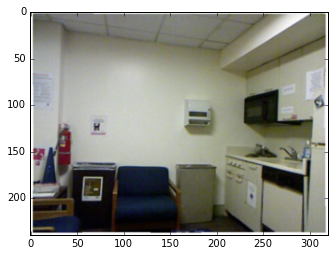

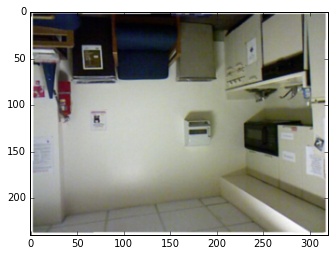

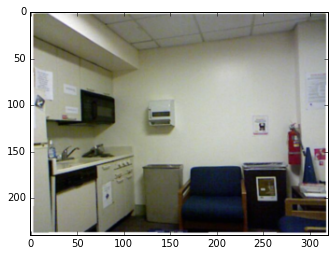

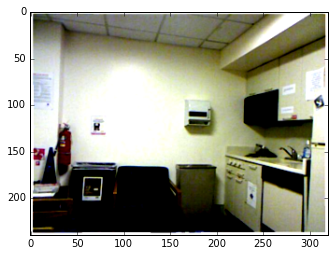

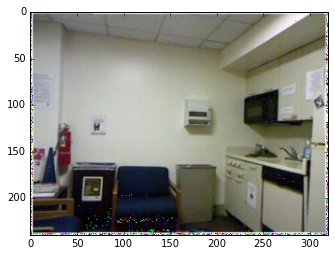

[[[255 254   2 ...,   0 255 254]
  [  2 254   1 ..., 255 254   3]
  [253 255 254 ..., 251 254 250]
  ..., 
  [254 253 242 ..., 253 254 252]
  [254   1 252 ...,   0 254 255]
  [254 254 255 ...,   1 255 254]]

 [[252 255 253 ..., 255 253 255]
  [255   3 254 ...,   0   0 254]
  [255 253 247 ..., 253 252 253]
  ..., 
  [255 252 239 ...,   0 255   0]
  [  0 254 250 ..., 253   1   0]
  [254 255 255 ..., 255 255   0]]

 [[  0 252 252 ..., 253 255 253]
  [253 252 254 ..., 252 255 255]
  [  0 253 254 ...,   0 254   0]
  ..., 
  [252   1 237 ..., 255 254 253]
  [253   1 254 ..., 251   0   1]
  [  1 252 255 ...,   0 255 254]]]


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
example = train_x[0]
plt.imshow(example.transpose((1,2,0)))
plt.show()

flipud = example[:,::-1,:]
plt.imshow(flipud.transpose((1,2,0)))
plt.show()

fliplr = example[:,:,::-1]
plt.imshow(fliplr.transpose((1,2,0)))
plt.show()

from deepgraph.utils.image import exposure_transformer, noise_transformer

exp = exposure_transformer(example, 100)
plt.imshow(exp.transpose((1,2,0)))
plt.show()

noise = noise_transformer(example, intensity=200)
plt.imshow(noise.transpose((1,2,0)))
plt.show()
print noise

In [5]:
#######################
# Data preprocessing
#######################
log("Preprocessing data", LOG_LEVEL_INFO)

# X
# Scale into 0-1 range
train_x = train_x.astype(np.float)
train_x *= 0.003921
# Subtract mean
train_mean = np.mean(train_x, axis=0)
idx = 0
for element in train_x:
    train_x[idx] = train_x[idx] - train_mean
    idx += 1
# Y
# Scale down by 100
train_y *= 0.01

[2016-03-19 18:41:20] INFO: Preprocessing data
